In [ ]:
from PIL import Image

In [ ]:
!git clone https://github.com/HitGobba2/deep-learning- flowers


fatal: destination path 'flowers' already exists and is not an empty directory.


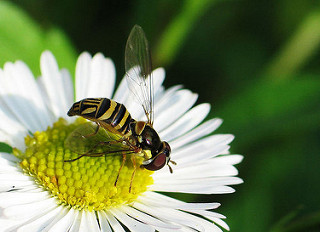

In [ ]:
im = Image.open('flowers/flowers/daisy/5547758_eea9edfd54_n.jpg')
im

#Imports

In [ ]:
#!pip install keras-tuner

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from sklearn.metrics import confusion_matrix as cm, classification_report as cr
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from keras import backend as K

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt


from keras.regularizers import l1_l2

from keras.applications.vgg16 import VGG16

from keras import optimizers

from keras.callbacks import EarlyStopping

from tensorflow.keras.applications.efficientnet import EfficientNetB7
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception
from keras.applications.mobilenet_v3 import MobileNetV3Small
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from datetime import datetime

from keras.regularizers import l2


# Data Loading and Pre-processing

In [ ]:
# Dictionary with the labels
classes = {0:'daisy',
           1:'dandelion',
           2:'rose',
           3:'sunflower',
           4:'tulip'           
           }


In [ ]:
#list  with class names
c_names = []

for i in range(len(classes)):
  c_names.append(classes[i])

In [ ]:
c_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
daisyImages = [f for f in listdir('flowers/flowers/daisy') if isfile(join('flowers/flowers/daisy', f))]
dandelionImages = [f for f in listdir('flowers/flowers/dandelion') if isfile(join('flowers/flowers/dandelion', f))]
roseImages = [f for f in listdir('flowers/flowers/rose') if isfile(join('flowers/flowers/rose', f))]
sunflowerImages = [f for f in listdir('flowers/flowers/sunflower') if isfile(join('flowers/flowers/sunflower', f))]
tulipImages = [f for f in listdir('flowers/flowers/tulip') if isfile(join('flowers/flowers/tulip', f))]

In [ ]:
imagePaths = daisyImages + dandelionImages + roseImages + sunflowerImages + tulipImages
len(imagePaths)

4317

In [ ]:
images = {0: daisyImages,
           1: dandelionImages,
           2: roseImages,
           3: sunflowerImages,
           4:tulipImages           
           }

### todo decide on the shapes

In [ ]:
def load_images_from_folder(folder, label):
    images = []
    totalHeight = 0
    totalWidth = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            # normalizing the image (deviding by the possible maximum value of a pixel)
            img = img / 255.0
            #calculating the appropriate size
            totalHeight += img.shape[0]
            totalWidth += img.shape[1]
            images.append(img)
            img = np.array(img)
            
    shape = ((totalHeight/len(images))/2,(totalWidth/len(images))/2)
    return images, [label for i in range(len(images))], shape

In [ ]:
imagesAll = []
labelsAll = []
full_shape = np.array((0.0,0.0))

for cLabel, cName in classes.items(): 

  folder = os.path.join('flowers/flowers/', cName)
  im, lab, shape = load_images_from_folder(folder, cLabel)
  imagesAll.extend(im)
  labelsAll.extend(lab)
  full_shape += np.array(shape)
  

full_shape = tuple(np.flip((full_shape/len(c_names)).astype(int),0))
print(full_shape)

for im in range(len(imagesAll)):
  imagesAll[im] = np.array(cv2.resize(imagesAll[im], full_shape))


(169, 126)


In [ ]:
imagesAll[0].shape

(126, 169, 3)

### Shuffle the image-label pairs 

In [ ]:
imagesAll = np.array(imagesAll)
labelsAll = np.array(labelsAll)
# to be able to track which image can be found where in the original dataset
indices = np.array([i for i in range(len(imagesAll))])
imagePaths = np.array(imagePaths)

In [ ]:
imagesAll,labelsAll, indices, imagePaths = shuffle(imagesAll, labelsAll, indices, imagePaths, random_state=42)

In [ ]:
imagesAll.shape

(4317, 126, 169, 3)

In [ ]:
np.array(labelsAll).shape

(4317,)

In [ ]:
np.array(imagesAll[0]).shape

(126, 169, 3)

In [ ]:
shape = np.array(imagesAll[0]).shape

In [ ]:
shape

(126, 169, 3)

### One-Hot Encoding the target labels

In [ ]:
labelsAll = to_categorical(labelsAll, len(classes))

In [ ]:
labelsAll[0]

array([0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
labelsAll[0].shape

(5,)

### Train-Test split

In [ ]:
#Performing the Train Test split manually, because of RAM limitations
trainSplitPoint = int(imagesAll.shape[0] * 0.6)
valSplitPoint = int(imagesAll.shape[0] * 0.8)
X_train = imagesAll[:trainSplitPoint]
X_val = imagesAll[trainSplitPoint:valSplitPoint]
X_test = imagesAll[valSplitPoint:]

y_train = labelsAll[:trainSplitPoint]
y_val = labelsAll[trainSplitPoint:valSplitPoint]
y_test = labelsAll[valSplitPoint:]


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2590, 126, 169, 3) (2590, 5)
(863, 126, 169, 3) (863, 5)
(864, 126, 169, 3) (864, 5)


In [ ]:
labelsAll[2000]

array([0., 0., 0., 0., 1.], dtype=float32)

# Metrics computing


In [ ]:
def f1_metric(y_true, y_pred):

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# defining the functions
def confusion_matrix(data_set, predictions):
    print('Confusion matrix')
    return cm(data_set, predictions)

def classification_report(data_set, predictions):
    print('Classification Report')
    target_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    print(cr(data_set, predictions, target_names=target_names))
    
def f1_plots(hist):
    f1 = hist.history['f1_metric']
    val_f1 = hist.history['val_f1_metric']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(f1) +1)

    plt.plot(epochs, f1, 'bo', label='Training F1 score')
    plt.plot(epochs, val_f1, 'b', label='Validation F1 score')
    plt.title('Training and validation F1 Score')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Callbacks

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping( # Once triggered, stops the training (if the val_f1 decreases 5 epochs in a row).
        monitor='val_f1_metric',
        patience=5),
    keras.callbacks.ModelCheckpoint( # Saves the best model observed during training (according to val_loss).
        filepath = 'cnn_model_file',
        monitor='val_loss',
        save_best_only=True)
]

In [ ]:
earlystopping = EarlyStopping(monitor ="val_f1_metric",  
                                        mode ="max", 
                                        patience =5,
                                        verbose=1,  
                                        restore_best_weights = True)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(#rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True)
 
test_datagen=ImageDataGenerator() 
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size=20) 
                                    
validation_generator = test_datagen.flow(X_val,y_val,
                                        batch_size=20)

### Classes of objects in test data

In [ ]:
test_arg = y_test.argmax(axis=1) #argmax gets the class with the highest probability

# Models without data augmentation


### Model 1

- 3 Convolutional layers (32-64-128, kernel 3x3, ReLU)
- Flattening
- 1 Dense layer (512, ReLU)
- 1 Dense layer (5, softmax)

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Conv2D(64, (3, 3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Conv2D(128, (3, 3), activation = 'relu'))
model_1.add(MaxPooling2D(pool_size = (2, 2)))

model_1.add(Flatten())

model_1.add(Dense(units = 512, activation = 'relu'))
model_1.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_1.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 83, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 38, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 19, 128)      0

In [ ]:
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 18s 87ms/step - loss: 1.4712 - f1_metric: 0.1950 - val_loss: 1.1487 - val_f1_metric: 0.4357
Epoch 2/50
81/81 [==============================] - 5s 64ms/step - loss: 1.0851 - f1_metric: 0.4818 - val_loss: 1.0427 - val_f1_metric: 0.5335
Epoch 3/50
81/81 [==============================] - 5s 64ms/step - loss: 0.9288 - f1_metric: 0.5973 - val_loss: 0.9441 - val_f1_metric: 0.5799
Epoch 4/50
81/81 [==============================] - 5s 64ms/step - loss: 0.7888 - f1_metric: 0.6800 - val_loss: 0.9135 - val_f1_metric: 0.5879
Epoch 5/50
81/81 [==============================] - 5s 63ms/step - loss: 0.6439 - f1_metric: 0.7447 - val_loss: 1.0402 - val_f1_metric: 0.6027
Epoch 6/50
81/81 [==============================] - 5s 64ms/step - loss: 0.4393 - f1_metric: 0.8410 - val_loss: 1.0426 - val_f1_metric: 0.6322
Epoch 7/50
81/81 [==============================] - 5s 64ms/step - loss: 0.2808 - f1_metric: 0.9025 - val_loss: 1.3652 - val_f1_metric: 0.596

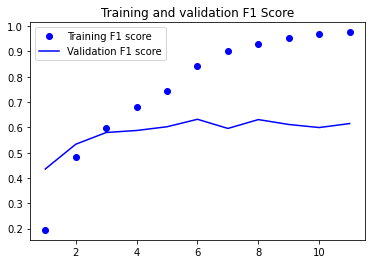

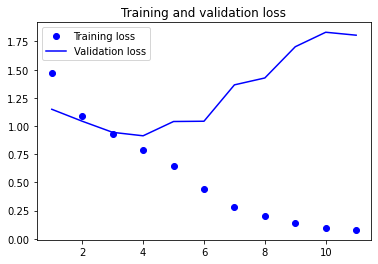

In [ ]:
f1_plots(history_1)

In [ ]:
y_pred = model_1.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[108  17   9   5   5]
 [ 32 143   8  17   6]
 [ 21  12  65   6  34]
 [ 12  28   3 120   9]
 [ 25  13  43  12 111]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.55      0.75      0.63       144
   dandelion       0.67      0.69      0.68       206
        rose       0.51      0.47      0.49       138
   sunflower       0.75      0.70      0.72       172
       tulip       0.67      0.54      0.60       204

    accuracy                           0.63       864
   macro avg       0.63      0.63      0.63       864
weighted avg       0.64      0.63      0.63       864

None


### Model 2

- 3 Convolutional layers (32-64-128, kernel 3x3, ReLU)
- Flattening
- 1 Dense layer (512, ReLU)
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

model_2.add(Conv2D(64, (3, 3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

model_2.add(Conv2D(128, (3, 3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2)))

model_2.add(Flatten())

model_2.add(Dense(units = 512, activation = 'relu'))
model_2.add(Dropout(rate=0.5))
model_2.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_2.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 83, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 38, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 19, 128)     

In [ ]:
history_2 = model_2.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 7s 70ms/step - loss: 1.3617 - f1_metric: 0.2229 - val_loss: 1.1138 - val_f1_metric: 0.3778
Epoch 2/50
81/81 [==============================] - 5s 64ms/step - loss: 1.0525 - f1_metric: 0.5122 - val_loss: 0.9587 - val_f1_metric: 0.6029
Epoch 3/50
81/81 [==============================] - 5s 64ms/step - loss: 0.8908 - f1_metric: 0.6335 - val_loss: 0.9524 - val_f1_metric: 0.5806
Epoch 4/50
81/81 [==============================] - 5s 64ms/step - loss: 0.7672 - f1_metric: 0.6942 - val_loss: 0.8726 - val_f1_metric: 0.6371
Epoch 5/50
81/81 [==============================] - 5s 64ms/step - loss: 0.6277 - f1_metric: 0.7554 - val_loss: 0.8953 - val_f1_metric: 0.6451
Epoch 6/50
81/81 [==============================] - 5s 64ms/step - loss: 0.4931 - f1_metric: 0.8165 - val_loss: 0.9430 - val_f1_metric: 0.6600
Epoch 7/50
81/81 [==============================] - 5s 65ms/step - loss: 0.3640 - f1_metric: 0.8700 - val_loss: 1.0894 - val_f1_metric: 0.6367

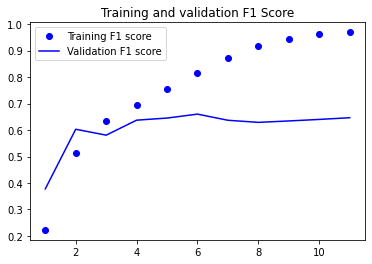

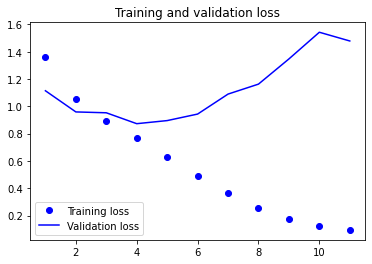

In [ ]:
f1_plots(history_2)

In [ ]:
y_pred = model_2.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[109  20   7   3   5]
 [ 25 159   6  10   6]
 [ 18  15  49   2  54]
 [ 11  22   5 117  17]
 [ 15  15  18   9 147]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.61      0.76      0.68       144
   dandelion       0.69      0.77      0.73       206
        rose       0.58      0.36      0.44       138
   sunflower       0.83      0.68      0.75       172
       tulip       0.64      0.72      0.68       204

    accuracy                           0.67       864
   macro avg       0.67      0.66      0.65       864
weighted avg       0.68      0.67      0.67       864

None


# Model 3

- 3 Convolutional layers (32-64-128, kernel 3x3 *with padding*, ReLU)
- Flattening
- 1 Dense layer (512, ReLU)
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), padding='same',input_shape = shape, activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))

model_3.add(Conv2D(64, (3, 3), padding='same',activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))

model_3.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2, 2)))

model_3.add(Flatten())

model_3.add(Dense(units = 512, activation = 'relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_3.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 169, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 84, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 63, 84, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 42, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 21, 128)     

In [ ]:
history_3 = model_3.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 8s 84ms/step - loss: 1.3230 - f1_metric: 0.2439 - val_loss: 1.0409 - val_f1_metric: 0.4800
Epoch 2/50
81/81 [==============================] - 6s 69ms/step - loss: 1.0114 - f1_metric: 0.5513 - val_loss: 0.9915 - val_f1_metric: 0.5314
Epoch 3/50
81/81 [==============================] - 6s 69ms/step - loss: 0.8496 - f1_metric: 0.6465 - val_loss: 0.8781 - val_f1_metric: 0.6252
Epoch 4/50
81/81 [==============================] - 6s 70ms/step - loss: 0.6862 - f1_metric: 0.7318 - val_loss: 0.8555 - val_f1_metric: 0.6585
Epoch 5/50
81/81 [==============================] - 6s 70ms/step - loss: 0.4945 - f1_metric: 0.8124 - val_loss: 0.9507 - val_f1_metric: 0.6658
Epoch 6/50
81/81 [==============================] - 6s 69ms/step - loss: 0.3454 - f1_metric: 0.8747 - val_loss: 1.0267 - val_f1_metric: 0.6559
Epoch 7/50
81/81 [==============================] - 6s 69ms/step - loss: 0.2440 - f1_metric: 0.9160 - val_loss: 1.2375 - val_f1_metric: 0.6360

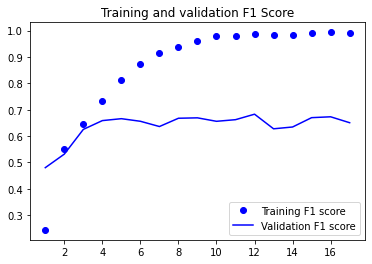

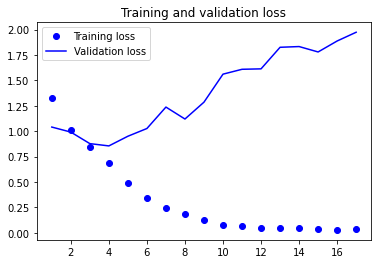

In [ ]:
f1_plots(history_3)

In [ ]:
y_pred = model_3.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[ 99  12  17   9   7]
 [ 20 144  10  18  14]
 [  8  11  67   1  51]
 [  7  34   6 113  12]
 [ 14  12  32   8 138]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.67      0.69      0.68       144
   dandelion       0.68      0.70      0.69       206
        rose       0.51      0.49      0.50       138
   sunflower       0.76      0.66      0.70       172
       tulip       0.62      0.68      0.65       204

    accuracy                           0.65       864
   macro avg       0.65      0.64      0.64       864
weighted avg       0.65      0.65      0.65       864

None


# Model 4

- 3 Convolutional layers (32-64-128, kernel 3x3 *with padding*, ReLU) + *Batch Normalization*
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2, 2)))
model_4.add(BatchNormalization())

model_4.add(Conv2D(64, (3, 3), activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2, 2)))
model_4.add(BatchNormalization())

model_4.add(Conv2D(128, (3, 3), activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2, 2)))
model_4.add(BatchNormalization())

model_4.add(Flatten())

model_4.add(Dense(units = 512, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(rate=0.5))
model_4.add(Dense(units = 5, activation = 'softmax'))


In [ ]:
model_4.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 83, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 62, 83, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                            
                                                      

In [ ]:
history_4 = model_4.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 8s 78ms/step - loss: 1.8094 - f1_metric: 0.4459 - val_loss: 1.9870 - val_f1_metric: 0.2516
Epoch 2/50
81/81 [==============================] - 6s 69ms/step - loss: 1.0167 - f1_metric: 0.6194 - val_loss: 2.8000 - val_f1_metric: 0.2339
Epoch 3/50
81/81 [==============================] - 6s 69ms/step - loss: 0.8458 - f1_metric: 0.6918 - val_loss: 1.6933 - val_f1_metric: 0.2714
Epoch 4/50
81/81 [==============================] - 6s 69ms/step - loss: 0.6287 - f1_metric: 0.7632 - val_loss: 1.7877 - val_f1_metric: 0.3154
Epoch 5/50
81/81 [==============================] - 6s 68ms/step - loss: 0.5190 - f1_metric: 0.8126 - val_loss: 1.1560 - val_f1_metric: 0.5085
Epoch 6/50
81/81 [==============================] - 6s 68ms/step - loss: 0.3410 - f1_metric: 0.8781 - val_loss: 1.0239 - val_f1_metric: 0.5767
Epoch 7/50
81/81 [==============================] - 6s 68ms/step - loss: 0.2608 - f1_metric: 0.9113 - val_loss: 0.9741 - val_f1_metric: 0.6172

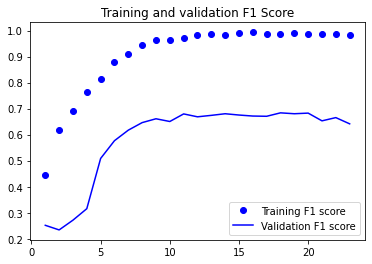

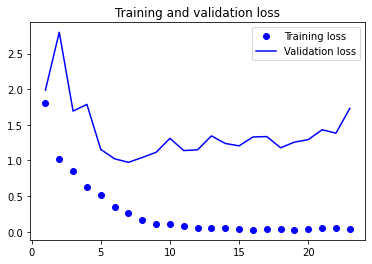

In [ ]:
f1_plots(history_4)

In [ ]:
y_pred = model_4.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[105  16  11   5   7]
 [ 24 156   6   8  12]
 [ 10  13  74   3  38]
 [ 10  30   1 120  11]
 [ 14  13  38  11 128]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.64      0.73      0.68       144
   dandelion       0.68      0.76      0.72       206
        rose       0.57      0.54      0.55       138
   sunflower       0.82      0.70      0.75       172
       tulip       0.65      0.63      0.64       204

    accuracy                           0.67       864
   macro avg       0.67      0.67      0.67       864
weighted avg       0.68      0.67      0.67       864

None


# Model 5

- 3 Convolutional layers (32-64-128, kernel 3x3 *with padding*, ReLU)
- 3 Convolutional layers (32-64-128, kernel 3x3, ReLU)
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_5 = Sequential()

model_5.add(Conv2D(32, (3, 3), padding='same',input_shape = shape, activation = 'relu'))
model_5.add(Conv2D(32, (3, 3), activation = 'relu'))
model_5.add(MaxPooling2D(pool_size = (2, 2)))

model_5.add(Conv2D(64, (3, 3), padding='same',activation = 'relu'))
model_5.add(Conv2D(64, (3, 3), activation = 'relu'))
model_5.add(MaxPooling2D(pool_size = (2, 2)))

model_5.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model_5.add(Conv2D(128, (3, 3), activation = 'relu'))
model_5.add(MaxPooling2D(pool_size = (2, 2)))

model_5.add(Flatten())

model_5.add(Dense(units = 512, activation = 'relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(rate=0.5))
model_5.add(Dense(units = 5, activation = 'softmax'))





In [ ]:
model_5.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 169, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 167, 32)      9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 62, 83, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 81, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                 

In [ ]:
history_5 = model_5.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 17s 174ms/step - loss: 1.5909 - f1_metric: 0.3103 - val_loss: 5.5236 - val_f1_metric: 0.2490
Epoch 2/50
81/81 [==============================] - 12s 144ms/step - loss: 1.3716 - f1_metric: 0.3329 - val_loss: 3.8599 - val_f1_metric: 0.2568
Epoch 3/50
81/81 [==============================] - 12s 144ms/step - loss: 1.2279 - f1_metric: 0.4144 - val_loss: 1.5942 - val_f1_metric: 0.4067
Epoch 4/50
81/81 [==============================] - 12s 144ms/step - loss: 1.2273 - f1_metric: 0.4555 - val_loss: 2.6789 - val_f1_metric: 0.3987
Epoch 5/50
81/81 [==============================] - 12s 144ms/step - loss: 1.1331 - f1_metric: 0.5018 - val_loss: 1.1980 - val_f1_metric: 0.5172
Epoch 6/50
81/81 [==============================] - 12s 144ms/step - loss: 1.1153 - f1_metric: 0.5094 - val_loss: 1.5119 - val_f1_metric: 0.4998
Epoch 7/50
81/81 [==============================] - 12s 143ms/step - loss: 1.0149 - f1_metric: 0.5839 - val_loss: 1.1968 - val_f1_

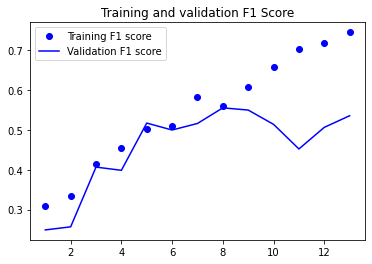

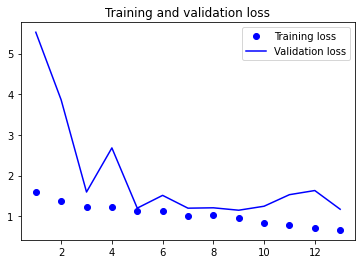

In [ ]:
f1_plots(history_5)

In [ ]:
y_pred = model_5.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[104  37   2   1   0]
 [ 23 167   2  13   1]
 [ 23  25  62   5  23]
 [ 25  55   5  82   5]
 [ 16  34  58  16  80]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.54      0.72      0.62       144
   dandelion       0.53      0.81      0.64       206
        rose       0.48      0.45      0.46       138
   sunflower       0.70      0.48      0.57       172
       tulip       0.73      0.39      0.51       204

    accuracy                           0.57       864
   macro avg       0.60      0.57      0.56       864
weighted avg       0.61      0.57      0.56       864

None


# Model 6

- 3 Convolutional layers (32-64-128, kernel 3x3, *Kernel_regularizers l1=0.01, l2=0.01*, ReLU) + *Batch Normalization*
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_6 = Sequential()

model_6.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_6.add(MaxPooling2D(pool_size = (2, 2)))
model_6.add(BatchNormalization())

model_6.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_6.add(MaxPooling2D(pool_size = (2, 2)))
model_6.add(BatchNormalization())

model_6.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_6.add(MaxPooling2D(pool_size = (2, 2)))
model_6.add(BatchNormalization())

model_6.add(Flatten())

model_6.add(Dense(units = 512, activation = 'relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(rate=0.5))
model_6.add(Dense(units = 5, activation = 'softmax'))


In [ ]:
model_6.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 62, 83, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                            
                                                      

In [ ]:
history_6 = model_6.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 8s 82ms/step - loss: 20.5558 - f1_metric: 0.4622 - val_loss: 9.9320 - val_f1_metric: 0.2193
Epoch 2/50
81/81 [==============================] - 6s 68ms/step - loss: 5.6142 - f1_metric: 0.5278 - val_loss: 4.8136 - val_f1_metric: 0.2322
Epoch 3/50
81/81 [==============================] - 5s 67ms/step - loss: 3.5832 - f1_metric: 0.5638 - val_loss: 4.0835 - val_f1_metric: 0.2258
Epoch 4/50
81/81 [==============================] - 5s 67ms/step - loss: 2.8533 - f1_metric: 0.6159 - val_loss: 4.0376 - val_f1_metric: 0.2258
Epoch 5/50
81/81 [==============================] - 5s 68ms/step - loss: 2.5582 - f1_metric: 0.6423 - val_loss: 4.1387 - val_f1_metric: 0.2258
Epoch 6/50
81/81 [==============================] - 6s 68ms/step - loss: 2.1261 - f1_metric: 0.6946 - val_loss: 2.8354 - val_f1_metric: 0.2862
Epoch 7/50
81/81 [==============================] - 5s 68ms/step - loss: 1.8873 - f1_metric: 0.7305 - val_loss: 2.8480 - val_f1_metric: 0.361

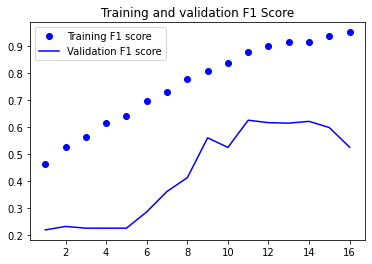

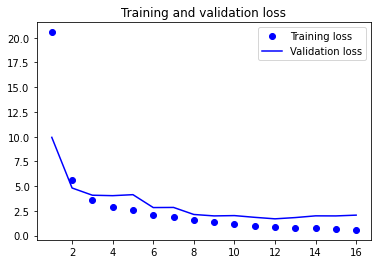

In [ ]:
f1_plots(history_6)

In [ ]:
y_pred = model_6.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[ 76  25  27   5  11]
 [  3 158   4  17  24]
 [  4  17  54   8  55]
 [  5  33   0 124  10]
 [  4  21  32  11 136]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.83      0.53      0.64       144
   dandelion       0.62      0.77      0.69       206
        rose       0.46      0.39      0.42       138
   sunflower       0.75      0.72      0.74       172
       tulip       0.58      0.67      0.62       204

    accuracy                           0.63       864
   macro avg       0.65      0.61      0.62       864
weighted avg       0.65      0.63      0.63       864

None


In [ ]:
print(co_mat)
print(classification_report(test_arg,pred_arg))

[[ 76  25  27   5  11]
 [  3 158   4  17  24]
 [  4  17  54   8  55]
 [  5  33   0 124  10]
 [  4  21  32  11 136]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.83      0.53      0.64       144
   dandelion       0.62      0.77      0.69       206
        rose       0.46      0.39      0.42       138
   sunflower       0.75      0.72      0.74       172
       tulip       0.58      0.67      0.62       204

    accuracy                           0.63       864
   macro avg       0.65      0.61      0.62       864
weighted avg       0.65      0.63      0.63       864

None


# Model 7

- 3 Convolutional layers (32-64-128, kernel 3x3, *with padding*, *Kernel_regularizers l1=0.01, l2=0.01*, ReLU)
- 3 Convolutional layers (32-64-128, kernel 3x3, *Kernel_regularizers l1=0.01, l2=0.01*, ReLU)+ *Batch Normalization*
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_7 = Sequential()

model_7.add(Conv2D(32, (3, 3), padding='same',input_shape = shape, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_7.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_7.add(MaxPooling2D(pool_size = (2, 2)))
model_7.add(BatchNormalization())

model_7.add(Conv2D(64, (3, 3), padding='same',activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_7.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_7.add(MaxPooling2D(pool_size = (2, 2)))
model_7.add(BatchNormalization())

model_7.add(Conv2D(128, (3, 3), padding='same', activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_7.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_7.add(MaxPooling2D(pool_size = (2, 2)))
model_7.add(BatchNormalization())

model_7.add(Flatten())

model_7.add(Dense(units = 512, activation = 'relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(rate=0.5))
model_7.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_7.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 169, 32)      896       
                                                                 
 conv2d_22 (Conv2D)          (None, 124, 167, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 62, 83, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_23 (Conv2D)          (None, 62, 83, 64)        18496     
                                                                 
 conv2d_24 (Conv2D)          (None, 60, 81, 64)       

In [ ]:
history_7 = model_7.fit(x=X_train,
                        y=y_train,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
81/81 [==============================] - 15s 165ms/step - loss: 53.5722 - f1_metric: 0.4428 - val_loss: 21.1807 - val_f1_metric: 0.2258
Epoch 2/50
81/81 [==============================] - 12s 147ms/step - loss: 10.8612 - f1_metric: 0.4990 - val_loss: 6.2634 - val_f1_metric: 1.1288e-08
Epoch 3/50
81/81 [==============================] - 12s 147ms/step - loss: 4.3323 - f1_metric: 0.5217 - val_loss: 3.6963 - val_f1_metric: 1.1288e-08
Epoch 4/50
81/81 [==============================] - 12s 146ms/step - loss: 2.9177 - f1_metric: 0.5182 - val_loss: 2.9967 - val_f1_metric: 1.1288e-08
Epoch 5/50
81/81 [==============================] - 12s 145ms/step - loss: 2.3061 - f1_metric: 0.5757 - val_loss: 2.7239 - val_f1_metric: 1.1171e-08
Epoch 6/50
81/81 [==============================] - 12s 146ms/step - loss: 2.0724 - f1_metric: 0.6015 - val_loss: 2.8286 - val_f1_metric: 0.2407
Epoch 7/50
81/81 [==============================] - 12s 146ms/step - loss: 1.8758 - f1_metric: 0.6304 - val_los

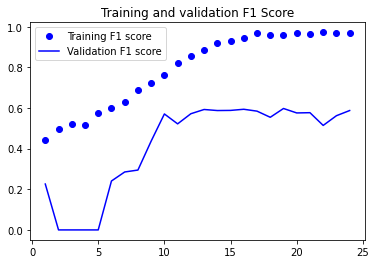

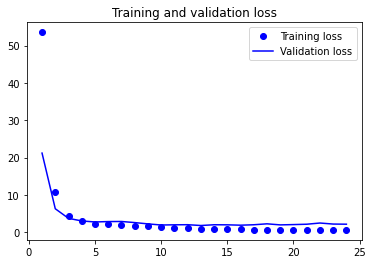

In [ ]:
f1_plots(history_7)

In [ ]:
y_pred = model_7.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[ 67  42  16   4  15]
 [  9 156   4  26  11]
 [  4  28  63   1  42]
 [  7  25   6 112  22]
 [ 11  21  51  16 105]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.68      0.47      0.55       144
   dandelion       0.57      0.76      0.65       206
        rose       0.45      0.46      0.45       138
   sunflower       0.70      0.65      0.68       172
       tulip       0.54      0.51      0.53       204

    accuracy                           0.58       864
   macro avg       0.59      0.57      0.57       864
weighted avg       0.59      0.58      0.58       864

None


# Models with data augmentation


### Model 8 (same as model 1, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3, ReLU)
- Flattening
- 1 Dense layer (512, ReLU)
- 1 Dense layer (5, softmax)

In [ ]:
model_8 = Sequential()

model_8.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
model_8.add(MaxPooling2D(pool_size = (2, 2)))

model_8.add(Conv2D(64, (3, 3), activation = 'relu'))
model_8.add(MaxPooling2D(pool_size = (2, 2)))

model_8.add(Conv2D(128, (3, 3), activation = 'relu'))
model_8.add(MaxPooling2D(pool_size = (2, 2)))

model_8.add(Flatten())

model_8.add(Dense(units = 512, activation = 'relu'))
model_8.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_8.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 38, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 14, 19, 128)     

In [ ]:
history_8 = model_8.fit(train_generator,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 17s 122ms/step - loss: 1.4381 - f1_metric: 0.1583 - val_loss: 1.1210 - val_f1_metric: 0.3184
Epoch 2/50
130/130 [==============================] - 15s 112ms/step - loss: 1.1632 - f1_metric: 0.4042 - val_loss: 0.9801 - val_f1_metric: 0.5259
Epoch 3/50
130/130 [==============================] - 15s 113ms/step - loss: 1.0265 - f1_metric: 0.5408 - val_loss: 0.9346 - val_f1_metric: 0.5796
Epoch 4/50
130/130 [==============================] - 15s 115ms/step - loss: 0.9894 - f1_metric: 0.5664 - val_loss: 0.9105 - val_f1_metric: 0.6140
Epoch 5/50
130/130 [==============================] - 15s 114ms/step - loss: 0.9270 - f1_metric: 0.6100 - val_loss: 0.8542 - val_f1_metric: 0.6379
Epoch 6/50
130/130 [==============================] - 15s 114ms/step - loss: 0.8975 - f1_metric: 0.6144 - val_loss: 0.8454 - val_f1_metric: 0.6546
Epoch 7/50
130/130 [==============================] - 15s 113ms/step - loss: 0.8802 - f1_metric: 0.6383 - val_loss: 0.

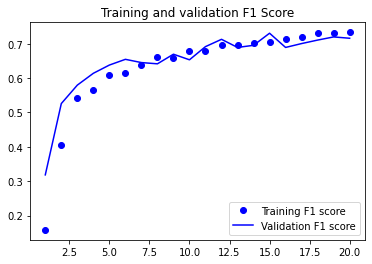

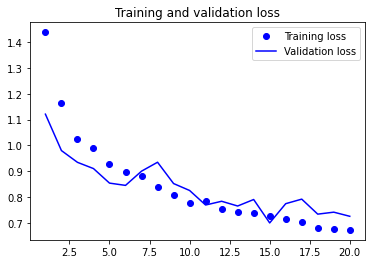

In [ ]:
f1_plots(history_8)

In [ ]:
y_pred = model_8.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[119   8  10   4   3]
 [ 20 155   6  21   4]
 [  3   9  81   6  39]
 [  3  15   3 146   5]
 [  3  11  42  10 138]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.80      0.83      0.82       144
   dandelion       0.78      0.75      0.77       206
        rose       0.57      0.59      0.58       138
   sunflower       0.78      0.85      0.81       172
       tulip       0.73      0.68      0.70       204

    accuracy                           0.74       864
   macro avg       0.73      0.74      0.74       864
weighted avg       0.74      0.74      0.74       864

None


### Model 9 (same as model 2, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3, ReLU)
- Flattening
- 1 Dense layer (512, ReLU)
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_9 = Sequential()

model_9.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
model_9.add(MaxPooling2D(pool_size = (2, 2)))

model_9.add(Conv2D(64, (3, 3), activation = 'relu'))
model_9.add(MaxPooling2D(pool_size = (2, 2)))

model_9.add(Conv2D(128, (3, 3), activation = 'relu'))
model_9.add(MaxPooling2D(pool_size = (2, 2)))

model_9.add(Flatten())

model_9.add(Dense(units = 512, activation = 'relu'))
model_9.add(Dropout(rate=0.5))
model_9.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_9.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 38, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 19, 128)     

In [ ]:
history_9 = model_9.fit(train_generator,
                        epochs=50,
                        validation_data=(X_val, y_val),
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 16s 119ms/step - loss: 1.3451 - f1_metric: 0.2237 - val_loss: 1.1115 - val_f1_metric: 0.4556
Epoch 2/50
130/130 [==============================] - 15s 116ms/step - loss: 1.1124 - f1_metric: 0.4442 - val_loss: 0.9462 - val_f1_metric: 0.5721
Epoch 3/50
130/130 [==============================] - 15s 115ms/step - loss: 1.0081 - f1_metric: 0.5429 - val_loss: 1.0110 - val_f1_metric: 0.5719
Epoch 4/50
130/130 [==============================] - 15s 116ms/step - loss: 0.9785 - f1_metric: 0.5700 - val_loss: 0.9647 - val_f1_metric: 0.6106
Epoch 5/50
130/130 [==============================] - 15s 117ms/step - loss: 0.9439 - f1_metric: 0.5921 - val_loss: 0.8338 - val_f1_metric: 0.6190
Epoch 6/50
130/130 [==============================] - 15s 117ms/step - loss: 0.8819 - f1_metric: 0.6195 - val_loss: 0.8341 - val_f1_metric: 0.6527
Epoch 7/50
130/130 [==============================] - 15s 119ms/step - loss: 0.8745 - f1_metric: 0.6241 - val_loss: 0.

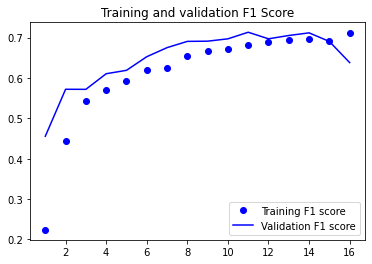

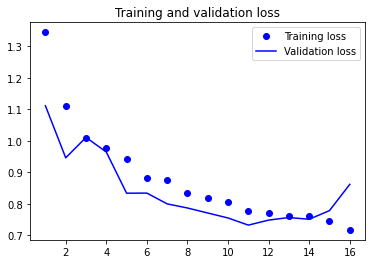

In [ ]:
f1_plots(history_9)

In [ ]:
y_pred = model_9.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[115   5  10   7   7]
 [ 20 143   8  22  13]
 [  5   6  66   4  57]
 [  6  15   3 136  12]
 [  7   5  22   9 161]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.75      0.80      0.77       144
   dandelion       0.82      0.69      0.75       206
        rose       0.61      0.48      0.53       138
   sunflower       0.76      0.79      0.78       172
       tulip       0.64      0.79      0.71       204

    accuracy                           0.72       864
   macro avg       0.72      0.71      0.71       864
weighted avg       0.72      0.72      0.72       864

None


# Model 10 (same as model 3, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3 *with padding*, ReLU)
- Flattening
- 1 Dense layer (512, ReLU)
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_10 = Sequential()

model_10.add(Conv2D(32, (3, 3), padding='same',input_shape = shape, activation = 'relu'))
model_10.add(MaxPooling2D(pool_size = (2, 2)))

model_10.add(Conv2D(64, (3, 3), padding='same',activation = 'relu'))
model_10.add(MaxPooling2D(pool_size = (2, 2)))

model_10.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model_10.add(MaxPooling2D(pool_size = (2, 2)))

model_10.add(Flatten())

model_10.add(Dense(units = 512, activation = 'relu'))
model_10.add(Dropout(rate=0.5))
model_10.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_10.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_10.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 126, 169, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 63, 84, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 63, 84, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 31, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 31, 42, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 15, 21, 128)     

In [ ]:
history_10 = model_10.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 17s 125ms/step - loss: 1.4105 - f1_metric: 0.1788 - val_loss: 1.1048 - val_f1_metric: 0.3922
Epoch 2/50
130/130 [==============================] - 16s 124ms/step - loss: 1.1322 - f1_metric: 0.4303 - val_loss: 0.9915 - val_f1_metric: 0.5627
Epoch 3/50
130/130 [==============================] - 16s 122ms/step - loss: 1.0699 - f1_metric: 0.4812 - val_loss: 0.9837 - val_f1_metric: 0.5462
Epoch 4/50
130/130 [==============================] - 16s 123ms/step - loss: 0.9915 - f1_metric: 0.5604 - val_loss: 0.8683 - val_f1_metric: 0.6263
Epoch 5/50
130/130 [==============================] - 16s 125ms/step - loss: 0.9369 - f1_metric: 0.5868 - val_loss: 0.8719 - val_f1_metric: 0.6357
Epoch 6/50
130/130 [==============================] - 16s 121ms/step - loss: 0.9170 - f1_metric: 0.5971 - val_loss: 0.8969 - val_f1_metric: 0.6324
Epoch 7/50
130/130 [==============================] - 16s 121ms/step - loss: 0.8677 - f1_metric: 0.6345 - val_loss: 0.

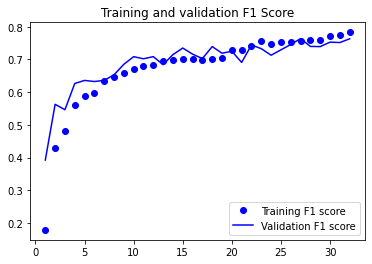

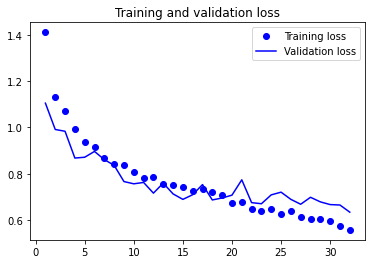

In [ ]:
f1_plots(history_10)

In [ ]:
y_pred = model_10.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[107  11  15   7   4]
 [ 15 140  20  27   4]
 [  4   3  93   5  33]
 [  1   8   4 155   4]
 [  4   8  43  16 133]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.82      0.74      0.78       144
   dandelion       0.82      0.68      0.74       206
        rose       0.53      0.67      0.59       138
   sunflower       0.74      0.90      0.81       172
       tulip       0.75      0.65      0.70       204

    accuracy                           0.73       864
   macro avg       0.73      0.73      0.72       864
weighted avg       0.74      0.73      0.73       864

None


# Model 11 (same as model 4, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3 *with padding*, ReLU) + *Batch Normalization*
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_11 = Sequential()

model_11.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
model_11.add(MaxPooling2D(pool_size = (2, 2)))
model_11.add(BatchNormalization())

model_11.add(Conv2D(64, (3, 3), activation = 'relu'))
model_11.add(MaxPooling2D(pool_size = (2, 2)))
model_11.add(BatchNormalization())

model_11.add(Conv2D(128, (3, 3), activation = 'relu'))
model_11.add(MaxPooling2D(pool_size = (2, 2)))
model_11.add(BatchNormalization())

model_11.add(Flatten())

model_11.add(Dense(units = 512, activation = 'relu'))
model_11.add(BatchNormalization())
model_11.add(Dropout(rate=0.5))
model_11.add(Dense(units = 5, activation = 'softmax'))


In [ ]:
model_11.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_11.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 62, 83, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
history_11 = model_11.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 17s 121ms/step - loss: 1.8724 - f1_metric: 0.4231 - val_loss: 2.3274 - val_f1_metric: 0.2615
Epoch 2/50
130/130 [==============================] - 15s 117ms/step - loss: 1.3971 - f1_metric: 0.4881 - val_loss: 4.4522 - val_f1_metric: 0.2262
Epoch 3/50
130/130 [==============================] - 16s 121ms/step - loss: 1.2476 - f1_metric: 0.5324 - val_loss: 2.1009 - val_f1_metric: 0.3532
Epoch 4/50
130/130 [==============================] - 15s 119ms/step - loss: 1.1351 - f1_metric: 0.5471 - val_loss: 1.4924 - val_f1_metric: 0.4349
Epoch 5/50
130/130 [==============================] - 16s 121ms/step - loss: 1.0738 - f1_metric: 0.5753 - val_loss: 0.9518 - val_f1_metric: 0.6330
Epoch 6/50
130/130 [==============================] - 16s 125ms/step - loss: 1.0147 - f1_metric: 0.6044 - val_loss: 1.0724 - val_f1_metric: 0.6209
Epoch 7/50
130/130 [==============================] - 16s 126ms/step - loss: 0.9751 - f1_metric: 0.6294 - val_loss: 1.

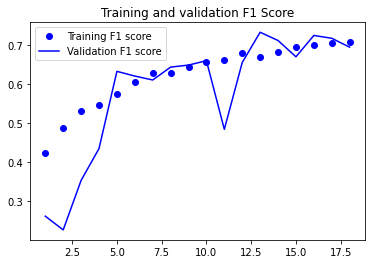

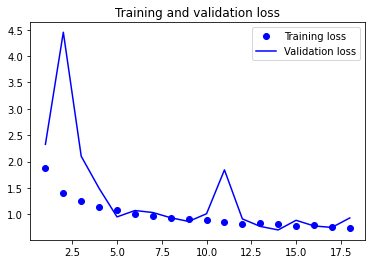

In [ ]:
f1_plots(history_11)

In [ ]:
y_pred = model_11.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[117   8  10   9   0]
 [ 16 152   3  33   2]
 [ 18  10  86   7  17]
 [  1  12   2 152   5]
 [ 13   9  44  15 123]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.71      0.81      0.76       144
   dandelion       0.80      0.74      0.77       206
        rose       0.59      0.62      0.61       138
   sunflower       0.70      0.88      0.78       172
       tulip       0.84      0.60      0.70       204

    accuracy                           0.73       864
   macro avg       0.73      0.73      0.72       864
weighted avg       0.74      0.73      0.73       864

None


# Model 12 (same as model 5, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3 *with padding*, ReLU)
- 3 Convolutional layers (32-64-128, kernel 3x3, ReLU)
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_12 = Sequential()

model_12.add(Conv2D(32, (3, 3), padding='same',input_shape = shape, activation = 'relu'))
model_12.add(Conv2D(32, (3, 3), activation = 'relu'))
model_12.add(MaxPooling2D(pool_size = (2, 2)))

model_12.add(Conv2D(64, (3, 3), padding='same',activation = 'relu'))
model_12.add(Conv2D(64, (3, 3), activation = 'relu'))
model_12.add(MaxPooling2D(pool_size = (2, 2)))

model_12.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
model_12.add(Conv2D(128, (3, 3), activation = 'relu'))
model_12.add(MaxPooling2D(pool_size = (2, 2)))

model_12.add(Flatten())

model_12.add(Dense(units = 512, activation = 'relu'))
model_12.add(BatchNormalization())
model_12.add(Dropout(rate=0.5))
model_12.add(Dense(units = 5, activation = 'softmax'))





In [ ]:
model_12.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_12.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 126, 169, 32)      896       
                                                                 
 conv2d_40 (Conv2D)          (None, 124, 167, 32)      9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 62, 83, 64)        18496     
                                                                 
 conv2d_42 (Conv2D)          (None, 60, 81, 64)        36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                

In [ ]:
history_12 = model_12.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 21s 151ms/step - loss: 1.4079 - f1_metric: 0.2254 - val_loss: 2.4932 - val_f1_metric: 0.2273
Epoch 2/50
130/130 [==============================] - 19s 146ms/step - loss: 1.2621 - f1_metric: 0.3511 - val_loss: 2.6443 - val_f1_metric: 0.2273
Epoch 3/50
130/130 [==============================] - 19s 146ms/step - loss: 1.2262 - f1_metric: 0.3926 - val_loss: 4.9144 - val_f1_metric: 0.1841
Epoch 4/50
130/130 [==============================] - 19s 142ms/step - loss: 1.1559 - f1_metric: 0.4493 - val_loss: 4.8463 - val_f1_metric: 0.2424
Epoch 5/50
130/130 [==============================] - 19s 143ms/step - loss: 1.1003 - f1_metric: 0.4980 - val_loss: 4.2632 - val_f1_metric: 0.2763
Epoch 6/50
130/130 [==============================] - 19s 143ms/step - loss: 1.0416 - f1_metric: 0.5390 - val_loss: 2.7487 - val_f1_metric: 0.2915
Epoch 7/50
130/130 [==============================] - 19s 142ms/step - loss: 1.0252 - f1_metric: 0.5678 - val_loss: 5.

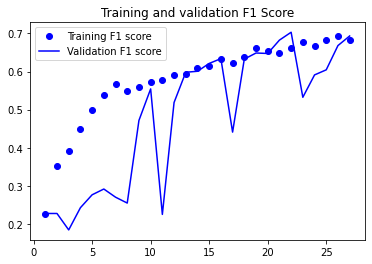

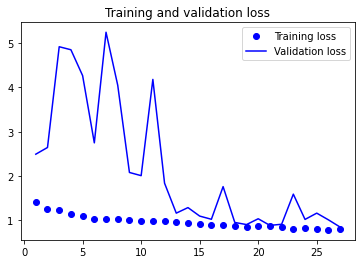

In [ ]:
f1_plots(history_12)

In [ ]:
y_pred = model_12.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[121  11   5   7   0]
 [ 16 165   5  20   0]
 [ 29  15  77   9   8]
 [ 11  20   2 139   0]
 [ 18  23  58  20  85]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.62      0.84      0.71       144
   dandelion       0.71      0.80      0.75       206
        rose       0.52      0.56      0.54       138
   sunflower       0.71      0.81      0.76       172
       tulip       0.91      0.42      0.57       204

    accuracy                           0.68       864
   macro avg       0.70      0.68      0.67       864
weighted avg       0.71      0.68      0.67       864

None


# Model 13 (same as model 6, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3, *Kernel_regularizers l1=0.01, l2=0.01*, ReLU) + *Batch Normalization*
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)

In [ ]:
model_13 = Sequential()

model_13.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_13.add(MaxPooling2D(pool_size = (2, 2)))
model_13.add(BatchNormalization())

model_13.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_13.add(MaxPooling2D(pool_size = (2, 2)))
model_13.add(BatchNormalization())

model_13.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_13.add(MaxPooling2D(pool_size = (2, 2)))
model_13.add(BatchNormalization())

model_13.add(Flatten())

model_13.add(Dense(units = 512, activation = 'relu'))
model_13.add(BatchNormalization())
model_13.add(Dropout(rate=0.5))
model_13.add(Dense(units = 5, activation = 'softmax'))


In [ ]:
model_13.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_13.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 124, 167, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 62, 83, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 60, 81, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 30, 40, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
history_13 = model_13.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 17s 123ms/step - loss: 16.6396 - f1_metric: 0.4141 - val_loss: 6.0455 - val_f1_metric: 0.0063
Epoch 2/50
130/130 [==============================] - 15s 118ms/step - loss: 4.4646 - f1_metric: 0.4135 - val_loss: 4.5677 - val_f1_metric: 0.2193
Epoch 3/50
130/130 [==============================] - 16s 122ms/step - loss: 3.3261 - f1_metric: 0.4390 - val_loss: 3.8966 - val_f1_metric: 0.2195
Epoch 4/50
130/130 [==============================] - 16s 120ms/step - loss: 2.6928 - f1_metric: 0.4601 - val_loss: 2.9916 - val_f1_metric: 0.2969
Epoch 5/50
130/130 [==============================] - 16s 119ms/step - loss: 2.3775 - f1_metric: 0.4916 - val_loss: 2.1709 - val_f1_metric: 0.5025
Epoch 6/50
130/130 [==============================] - 16s 121ms/step - loss: 2.0967 - f1_metric: 0.4890 - val_loss: 2.0676 - val_f1_metric: 0.4951
Epoch 7/50
130/130 [==============================] - 16s 120ms/step - loss: 1.9334 - f1_metric: 0.5097 - val_loss: 1

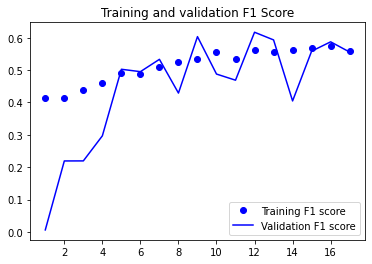

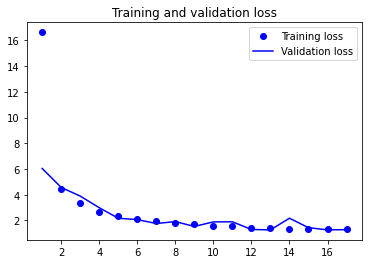

In [ ]:
f1_plots(history_13)

In [ ]:
y_pred = model_13.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[112  16   8   8   0]
 [ 35 148   6  16   1]
 [ 21  12  73  10  22]
 [ 10  26   3 132   1]
 [ 21  22  52  14  95]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.56      0.78      0.65       144
   dandelion       0.66      0.72      0.69       206
        rose       0.51      0.53      0.52       138
   sunflower       0.73      0.77      0.75       172
       tulip       0.80      0.47      0.59       204

    accuracy                           0.65       864
   macro avg       0.65      0.65      0.64       864
weighted avg       0.67      0.65      0.64       864

None


# Model 14 (same as model 7, but with data augmentation)

- 3 Convolutional layers (32-64-128, kernel 3x3, *with padding*, *Kernel_regularizers l1=0.01, l2=0.01*, ReLU)
- 3 Convolutional layers (32-64-128, kernel 3x3, *Kernel_regularizers l1=0.01, l2=0.01*, ReLU)+ *Batch Normalization*
- Flattening
- 1 Dense layer (512, ReLU) + *Batch Normalization*
- Dropout (rate=0.5)
- 1 Dense layer (5, softmax)


In [ ]:
model_14 = Sequential()

model_14.add(Conv2D(32, (3, 3), padding='same',input_shape = shape, activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_14.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_14.add(MaxPooling2D(pool_size = (2, 2)))
model_14.add(BatchNormalization())

model_14.add(Conv2D(64, (3, 3), padding='same',activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_14.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_14.add(MaxPooling2D(pool_size = (2, 2)))
model_14.add(BatchNormalization())

model_14.add(Conv2D(128, (3, 3), padding='same', activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_14.add(Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
model_14.add(MaxPooling2D(pool_size = (2, 2)))
model_14.add(BatchNormalization())

model_14.add(Flatten())

model_14.add(Dense(units = 512, activation = 'relu'))
model_14.add(BatchNormalization())
model_14.add(Dropout(rate=0.5))
model_14.add(Dense(units = 5, activation = 'softmax'))

In [ ]:
model_14.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = [f1_metric])

In [ ]:
model_14.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 126, 169, 32)      896       
                                                                 
 conv2d_49 (Conv2D)          (None, 124, 167, 32)      9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 62, 83, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 62, 83, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_50 (Conv2D)          (None, 62, 83, 64)        18496     
                                                                 
 conv2d_51 (Conv2D)          (None, 60, 81, 64)      

In [ ]:
history_14 = model_14.fit(train_generator,
                        epochs=50,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/50
130/130 [==============================] - 21s 150ms/step - loss: 41.2142 - f1_metric: 0.3809 - val_loss: 11.4685 - val_f1_metric: 0.2258
Epoch 2/50
130/130 [==============================] - 19s 146ms/step - loss: 6.3442 - f1_metric: 0.3489 - val_loss: 4.0460 - val_f1_metric: 1.1288e-08
Epoch 3/50
130/130 [==============================] - 19s 146ms/step - loss: 3.1516 - f1_metric: 0.3783 - val_loss: 2.7955 - val_f1_metric: 1.1288e-08
Epoch 4/50
130/130 [==============================] - 19s 145ms/step - loss: 2.4901 - f1_metric: 0.3663 - val_loss: 2.4169 - val_f1_metric: 0.1109
Epoch 5/50
130/130 [==============================] - 19s 144ms/step - loss: 2.2408 - f1_metric: 0.4104 - val_loss: 2.2072 - val_f1_metric: 0.3574
Epoch 6/50
130/130 [==============================] - 19s 144ms/step - loss: 1.9874 - f1_metric: 0.4849 - val_loss: 1.8685 - val_f1_metric: 0.4617
Epoch 7/50
130/130 [==============================] - 19s 144ms/step - loss: 1.8572 - f1_metric: 0.4992 - va

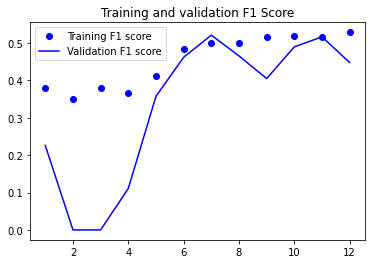

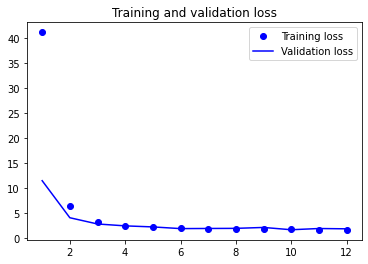

In [ ]:
f1_plots(history_14)

In [ ]:
y_pred = model_14.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[ 52  56   0  34   2]
 [  3 178   0  24   1]
 [  6  59  18   6  49]
 [  2  46   0 124   0]
 [  2  81  10  26  85]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.80      0.36      0.50       144
   dandelion       0.42      0.86      0.57       206
        rose       0.64      0.13      0.22       138
   sunflower       0.58      0.72      0.64       172
       tulip       0.62      0.42      0.50       204

    accuracy                           0.53       864
   macro avg       0.61      0.50      0.48       864
weighted avg       0.60      0.53      0.50       864

None


In [ ]:
model_14.save_weights('model_14.h14')

In [ ]:
model_14.save('model_14.h14')

INFO:tensorflow:Assets written to: model_14.h14/assets


# Transferlearning

### Model 15 -  VGG16

In [ ]:
# VGG16
vgg = VGG16(input_shape=shape,
            weights='imagenet', 
            include_top=False)


for layer in vgg.layers:
    layer.trainable = False
    

x = Flatten()(vgg.output)

x = Dense(units = 512, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(units = 5, activation='softmax')(x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16 = Model(inputs=vgg.input, outputs=x)

vgg16.compile(optimizer = 'adam',
                  loss='categorical_crossentropy', 
                  metrics=[f1_metric, 'accuracy'])



history_vgg = vgg16.fit(train_generator,
                        epochs=30,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/30
130/130 [==============================] - 30s 207ms/step - loss: 1.1441 - f1_metric: 0.6260 - accuracy: 0.6255 - val_loss: 0.7070 - val_f1_metric: 0.7413 - val_accuracy: 0.7428
Epoch 2/30
130/130 [==============================] - 24s 185ms/step - loss: 0.8404 - f1_metric: 0.6935 - accuracy: 0.6985 - val_loss: 0.5511 - val_f1_metric: 0.7995 - val_accuracy: 0.7926
Epoch 3/30
130/130 [==============================] - 24s 184ms/step - loss: 0.7393 - f1_metric: 0.7185 - accuracy: 0.7259 - val_loss: 0.6102 - val_f1_metric: 0.7681 - val_accuracy: 0.7601
Epoch 4/30
130/130 [==============================] - 24s 182ms/step - loss: 0.7023 - f1_metric: 0.7306 - accuracy: 0.7347 - val_loss: 0.6391 - val_f1_metric: 0.7650 - val_accuracy: 0.7764
Epoch 5/30
130/130 [==============================] - 24s 184ms/step - loss: 0.6748 - f1_metric: 0.7472 - accuracy: 0.7537 - val_loss: 0.5390 - val_f1_metric: 0.7965 - val_accuracy: 0.7972
Epoch 6/30
130/130 [==============================] - 2

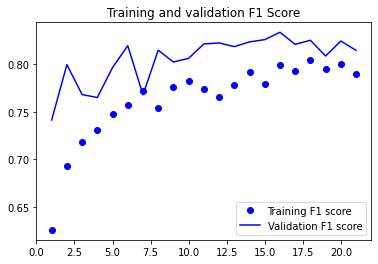

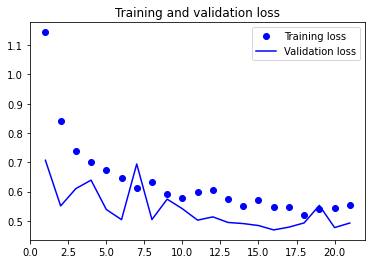

In [ ]:
f1_plots(history_vgg)

In [ ]:
y_pred = vgg16.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[111   9   4  12   8]
 [ 10 176   2   8  10]
 [  5   4  89   5  35]
 [  3   8   4 147  10]
 [  3   5  16   9 171]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.84      0.77      0.80       144
   dandelion       0.87      0.85      0.86       206
        rose       0.77      0.64      0.70       138
   sunflower       0.81      0.85      0.83       172
       tulip       0.73      0.84      0.78       204

    accuracy                           0.80       864
   macro avg       0.81      0.79      0.80       864
weighted avg       0.81      0.80      0.80       864

None


### Model 16 -  EfficientNetB7

In [ ]:
# EfficientNetB7

e_net = EfficientNetB7(input_shape=shape,
                       weights='imagenet', 
                       include_top=False)

for layer in e_net.layers:
    layer.trainable = False
    

y = Flatten()(e_net.output)

y = Dense(units = 512, activation = 'relu')(y)
y = BatchNormalization()(y)
y = Dropout(rate=0.5)(y)
y = Dense(units = 5, activation='softmax')(y)

258088960/258076736 [==============================] - 2s 0us/step


In [ ]:
enetb7 = Model(inputs=e_net.input, outputs=y)

enetb7.compile(optimizer = 'adam',
                    loss='categorical_crossentropy', 
                    metrics=[f1_metric, 'accuracy'])


history_enetb7 = enetb7.fit(train_generator,
                        epochs=30,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/30
130/130 [==============================] - 91s 474ms/step - loss: 1.8653 - f1_metric: 0.0611 - accuracy: 0.2104 - val_loss: 2.8292 - val_f1_metric: 0.2337 - val_accuracy: 0.2317
Epoch 2/30
130/130 [==============================] - 52s 398ms/step - loss: 1.7678 - f1_metric: 0.0474 - accuracy: 0.2178 - val_loss: 1.7699 - val_f1_metric: 1.1288e-08 - val_accuracy: 0.3082
Epoch 3/30
130/130 [==============================] - 52s 397ms/step - loss: 1.7404 - f1_metric: 0.0386 - accuracy: 0.2251 - val_loss: 2.7234 - val_f1_metric: 0.1886 - val_accuracy: 0.1924
Epoch 4/30
130/130 [==============================] - 52s 398ms/step - loss: 1.7049 - f1_metric: 0.0243 - accuracy: 0.2174 - val_loss: 1.6369 - val_f1_metric: 1.1288e-08 - val_accuracy: 0.2236
Epoch 5/30
130/130 [==============================] - 52s 397ms/step - loss: 1.6730 - f1_metric: 0.0207 - accuracy: 0.2266 - val_loss: 1.6049 - val_f1_metric: 1.1288e-08 - val_accuracy: 0.2236
Epoch 6/30
130/130 [=======================

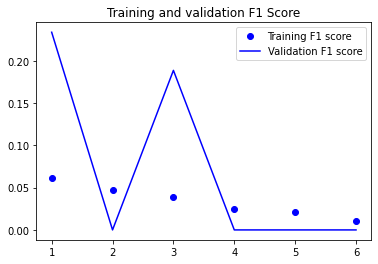

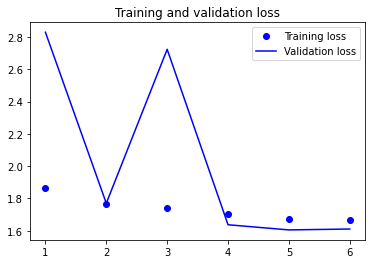

In [ ]:
f1_plots(history_enetb7)

In [ ]:
y_pred = enetb7.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[  0   0   0   0 144]
 [  0   0   0   0 206]
 [  0   0   0   0 138]
 [  0   0   0   0 172]
 [  0   0   0   0 204]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       144
   dandelion       0.00      0.00      0.00       206
        rose       0.00      0.00      0.00       138
   sunflower       0.00      0.00      0.00       172
       tulip       0.24      1.00      0.38       204

    accuracy                           0.24       864
   macro avg       0.05      0.20      0.08       864
weighted avg       0.06      0.24      0.09       864

None


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 17 -  ResNet152V2

In [ ]:
resnet = ResNet152V2(input_shape=shape,
                     weights='imagenet', 
                     include_top=False)

for layer in resnet.layers:
    layer.trainable = False
    

z = Flatten()(resnet.output)

z = Dense(units = 512, activation = 'relu')(z)
z = BatchNormalization()(z)
z = Dropout(rate=0.5)(z)
z = Dense(units = 5, activation='softmax')(z)

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
resnet152v2 = Model(inputs=resnet.input, outputs=z)

resnet152v2.compile(optimizer = 'adam',
                    loss='categorical_crossentropy', 
                    metrics=[f1_metric, 'accuracy'])


history_resnet152v2 = resnet152v2.fit(train_generator,
                        epochs=30,
                        validation_data=validation_generator,
                        callbacks = [earlystopping]
                      )

Epoch 1/30
130/130 [==============================] - 54s 324ms/step - loss: 1.2171 - f1_metric: 0.6399 - accuracy: 0.6413 - val_loss: 0.6645 - val_f1_metric: 0.7837 - val_accuracy: 0.7798
Epoch 2/30
130/130 [==============================] - 37s 284ms/step - loss: 0.7934 - f1_metric: 0.7223 - accuracy: 0.7236 - val_loss: 0.5612 - val_f1_metric: 0.7857 - val_accuracy: 0.7868
Epoch 3/30
130/130 [==============================] - 37s 283ms/step - loss: 0.6753 - f1_metric: 0.7631 - accuracy: 0.7625 - val_loss: 0.5079 - val_f1_metric: 0.8201 - val_accuracy: 0.8204
Epoch 4/30
130/130 [==============================] - 36s 280ms/step - loss: 0.6252 - f1_metric: 0.7747 - accuracy: 0.7726 - val_loss: 0.5207 - val_f1_metric: 0.8086 - val_accuracy: 0.8100
Epoch 5/30
130/130 [==============================] - 37s 281ms/step - loss: 0.5838 - f1_metric: 0.7849 - accuracy: 0.7815 - val_loss: 0.5710 - val_f1_metric: 0.8125 - val_accuracy: 0.8100
Epoch 6/30
130/130 [==============================] - 3

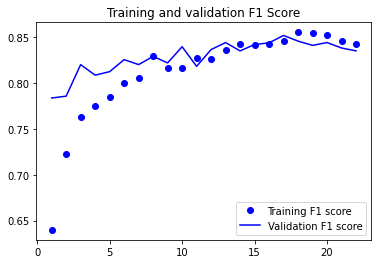

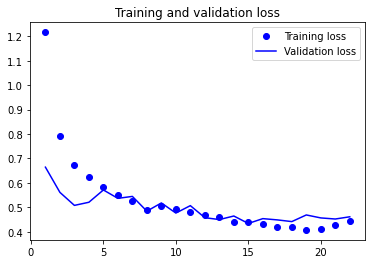

In [ ]:
f1_plots(history_resnet152v2)

In [ ]:
y_pred = resnet152v2.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[110  22   5   5   2]
 [  8 183   2   2  11]
 [  5   7 107   4  15]
 [  2  15  14 129  12]
 [  2   8  18   6 170]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.87      0.76      0.81       144
   dandelion       0.78      0.89      0.83       206
        rose       0.73      0.78      0.75       138
   sunflower       0.88      0.75      0.81       172
       tulip       0.81      0.83      0.82       204

    accuracy                           0.81       864
   macro avg       0.81      0.80      0.81       864
weighted avg       0.81      0.81      0.81       864

None


### Model 18 -  Xception

In [ ]:
xcep = Xception(input_shape=shape,
                weights='imagenet',
                include_top=False)

for layer in xcep.layers:
    layer.trainable = False
    

w = Flatten()(xcep.output)

w = Dense(units = 512, activation = 'relu')(w)
w = BatchNormalization()(w)
w = Dropout(rate=0.5)(w)
w = Dense(units = 5, activation='softmax')(w)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
xception = Model(inputs=xcep.input, outputs=w)

xception.compile(optimizer = 'adam',
                 loss='categorical_crossentropy', 
                 metrics=[f1_metric, 'accuracy'])


history_xception = xception.fit(train_generator,
                                epochs=30,
                                validation_data=validation_generator,
                                callbacks = [earlystopping]
                              )

Epoch 1/30
130/130 [==============================] - 30s 197ms/step - loss: 1.2224 - f1_metric: 0.6146 - accuracy: 0.6131 - val_loss: 0.6601 - val_f1_metric: 0.7470 - val_accuracy: 0.7659
Epoch 2/30
130/130 [==============================] - 23s 177ms/step - loss: 0.8240 - f1_metric: 0.7196 - accuracy: 0.7170 - val_loss: 0.5687 - val_f1_metric: 0.7926 - val_accuracy: 0.7914
Epoch 3/30
130/130 [==============================] - 23s 177ms/step - loss: 0.7383 - f1_metric: 0.7337 - accuracy: 0.7293 - val_loss: 0.4586 - val_f1_metric: 0.8372 - val_accuracy: 0.8366
Epoch 4/30
130/130 [==============================] - 23s 176ms/step - loss: 0.7154 - f1_metric: 0.7347 - accuracy: 0.7344 - val_loss: 0.5199 - val_f1_metric: 0.8087 - val_accuracy: 0.8053
Epoch 5/30
130/130 [==============================] - 23s 175ms/step - loss: 0.6668 - f1_metric: 0.7551 - accuracy: 0.7571 - val_loss: 0.4953 - val_f1_metric: 0.7971 - val_accuracy: 0.8158
Epoch 6/30
130/130 [==============================] - 2

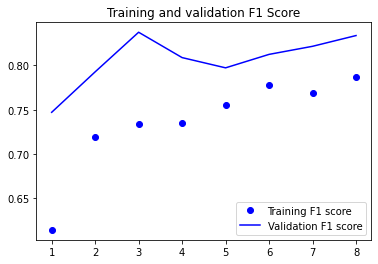

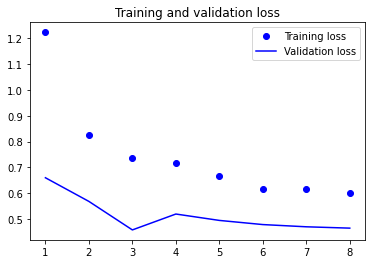

In [ ]:
f1_plots(history_xception)

In [ ]:
y_pred = xception.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[119   7  10   4   4]
 [ 14 170   6   7   9]
 [  6   3 106   3  20]
 [  5   7  24 119  17]
 [  2   1  33   8 160]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.82      0.83      0.82       144
   dandelion       0.90      0.83      0.86       206
        rose       0.59      0.77      0.67       138
   sunflower       0.84      0.69      0.76       172
       tulip       0.76      0.78      0.77       204

    accuracy                           0.78       864
   macro avg       0.78      0.78      0.78       864
weighted avg       0.79      0.78      0.78       864

None


### Model 19 -  MobileNetV3Small

In [ ]:
mobnetv3 = MobileNetV3Small(input_shape=shape,
                            weights='imagenet',
                            include_top=False)

for layer in mobnetv3.layers:
    layer.trainable = False
    

v = Flatten()(mobnetv3.output)

v = Dense(units = 512, activation = 'relu')(v)
v = BatchNormalization()(v)
v = Dropout(rate=0.5)(v)
v = Dense(units = 5, activation='softmax')(v)

4349952/4334752 [==============================] - 0s 0us/step


In [ ]:
mobnetv3small = Model(inputs=mobnetv3.input, outputs=v)

mobnetv3small.compile(optimizer = 'adam',
                 loss='categorical_crossentropy', 
                 metrics=[f1_metric, 'accuracy'])


history_mobnetv3small = mobnetv3small.fit(train_generator,
                                epochs=30,
                                validation_data=validation_generator,
                                callbacks = [earlystopping]
                              )

Epoch 1/30
130/130 [==============================] - 22s 134ms/step - loss: 1.6713 - f1_metric: 0.2398 - accuracy: 0.3552 - val_loss: 12.3489 - val_f1_metric: 0.1883 - val_accuracy: 0.1854
Epoch 2/30
130/130 [==============================] - 15s 119ms/step - loss: 1.5233 - f1_metric: 0.2627 - accuracy: 0.3938 - val_loss: 7.4680 - val_f1_metric: 0.1659 - val_accuracy: 0.1692
Epoch 3/30
130/130 [==============================] - 16s 121ms/step - loss: 1.4468 - f1_metric: 0.2670 - accuracy: 0.4135 - val_loss: 8.6324 - val_f1_metric: 0.1636 - val_accuracy: 0.1669
Epoch 4/30
130/130 [==============================] - 16s 120ms/step - loss: 1.4116 - f1_metric: 0.2991 - accuracy: 0.4266 - val_loss: 11.0189 - val_f1_metric: 0.1701 - val_accuracy: 0.1669
Epoch 5/30
130/130 [==============================] - 16s 119ms/step - loss: 1.3907 - f1_metric: 0.2791 - accuracy: 0.4313 - val_loss: 4.5352 - val_f1_metric: 0.1706 - val_accuracy: 0.1738
Epoch 6/30
130/130 [==============================] -

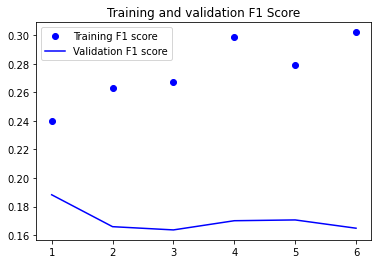

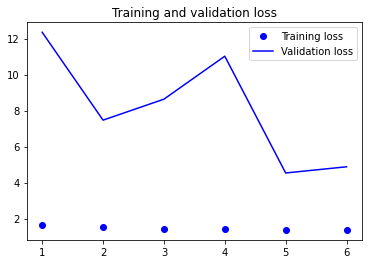

In [ ]:
f1_plots(history_mobnetv3small)

In [ ]:
y_pred = mobnetv3small.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[144   0   0   0   0]
 [206   0   0   0   0]
 [138   0   0   0   0]
 [172   0   0   0   0]
 [204   0   0   0   0]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.17      1.00      0.29       144
   dandelion       0.00      0.00      0.00       206
        rose       0.00      0.00      0.00       138
   sunflower       0.00      0.00      0.00       172
       tulip       0.00      0.00      0.00       204

    accuracy                           0.17       864
   macro avg       0.03      0.20      0.06       864
weighted avg       0.03      0.17      0.05       864

None


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 20 -  ResNet50V2

In [ ]:
resnet50 = ResNet50V2(input_shape=shape,
                      weights='imagenet',
                      include_top=False)

for layer in resnet50.layers:
    layer.trainable = False
    

u = Flatten()(resnet50.output)

u = Dense(units = 512, activation = 'relu')(u)
u = BatchNormalization()(u)
u = Dropout(rate=0.5)(u)
u = Dense(units = 5, activation='softmax')(u)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet50v2 = Model(inputs=resnet50.input, outputs=u)

resnet50v2.compile(optimizer = 'adam',
                 loss='categorical_crossentropy', 
                 metrics=[f1_metric, 'accuracy'])


history_resnet50v2 = resnet50v2.fit(train_generator,
                                epochs=30,
                                validation_data=validation_generator,
                                callbacks = [earlystopping]
                              )

Epoch 1/30
130/130 [==============================] - 27s 176ms/step - loss: 1.1485 - f1_metric: 0.6674 - accuracy: 0.6649 - val_loss: 0.6742 - val_f1_metric: 0.7985 - val_accuracy: 0.7879
Epoch 2/30
130/130 [==============================] - 21s 164ms/step - loss: 0.7488 - f1_metric: 0.7345 - accuracy: 0.7394 - val_loss: 0.5455 - val_f1_metric: 0.8141 - val_accuracy: 0.8100
Epoch 3/30
130/130 [==============================] - 21s 164ms/step - loss: 0.6934 - f1_metric: 0.7514 - accuracy: 0.7552 - val_loss: 0.5249 - val_f1_metric: 0.8218 - val_accuracy: 0.8111
Epoch 4/30
130/130 [==============================] - 21s 163ms/step - loss: 0.6383 - f1_metric: 0.7740 - accuracy: 0.7718 - val_loss: 0.5120 - val_f1_metric: 0.8032 - val_accuracy: 0.8123
Epoch 5/30
130/130 [==============================] - 21s 163ms/step - loss: 0.5857 - f1_metric: 0.7904 - accuracy: 0.7892 - val_loss: 0.4723 - val_f1_metric: 0.8303 - val_accuracy: 0.8308
Epoch 6/30
130/130 [==============================] - 2

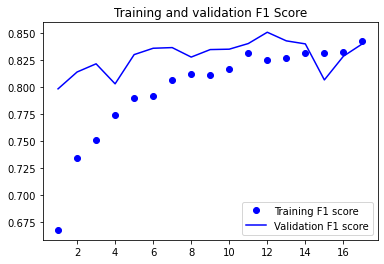

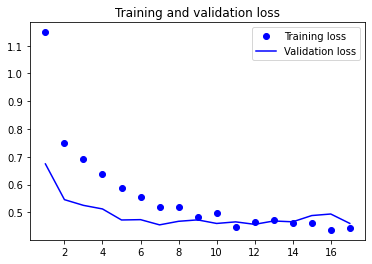

In [ ]:
f1_plots(history_resnet50v2)

In [ ]:
y_pred = resnet50v2.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[107  18   5   6   8]
 [  7 172   2  10  15]
 [  1   6  98   7  26]
 [  3   7  11 138  13]
 [  0   8  20   4 172]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.91      0.74      0.82       144
   dandelion       0.82      0.83      0.82       206
        rose       0.72      0.71      0.72       138
   sunflower       0.84      0.80      0.82       172
       tulip       0.74      0.84      0.79       204

    accuracy                           0.80       864
   macro avg       0.80      0.79      0.79       864
weighted avg       0.80      0.80      0.80       864

None


### Model 21 -  InceptionV3

In [ ]:
incep = InceptionV3(input_shape=shape,
                    weights='imagenet',
                    include_top=False)
for layer in incep.layers:
    layer.trainable = False
    

t = Flatten()(incep.output)

t = Dense(units = 512, activation = 'relu')(t)
t = BatchNormalization()(t)
t = Dropout(rate=0.5)(t)
t = Dense(units = 5, activation='softmax')(t)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
incepv3 = Model(inputs=incep.input, outputs=t)

incepv3.compile(optimizer = 'adam',
                 loss='categorical_crossentropy', 
                 metrics=[f1_metric, 'accuracy'])


history_incepv3 = incepv3.fit(train_generator,
                                epochs=30,
                                validation_data=validation_generator,
                                callbacks = [earlystopping]
                              )

Epoch 1/30
130/130 [==============================] - 30s 176ms/step - loss: 1.1799 - f1_metric: 0.6069 - accuracy: 0.6104 - val_loss: 0.8542 - val_f1_metric: 0.6883 - val_accuracy: 0.6964
Epoch 2/30
130/130 [==============================] - 19s 148ms/step - loss: 0.9014 - f1_metric: 0.6672 - accuracy: 0.6745 - val_loss: 0.7363 - val_f1_metric: 0.7277 - val_accuracy: 0.7242
Epoch 3/30
130/130 [==============================] - 19s 146ms/step - loss: 0.8112 - f1_metric: 0.6915 - accuracy: 0.6985 - val_loss: 0.5813 - val_f1_metric: 0.7629 - val_accuracy: 0.7856
Epoch 4/30
130/130 [==============================] - 19s 147ms/step - loss: 0.7751 - f1_metric: 0.7004 - accuracy: 0.7066 - val_loss: 0.5844 - val_f1_metric: 0.7876 - val_accuracy: 0.7856
Epoch 5/30
130/130 [==============================] - 19s 144ms/step - loss: 0.7566 - f1_metric: 0.7179 - accuracy: 0.7201 - val_loss: 0.5942 - val_f1_metric: 0.7655 - val_accuracy: 0.7717
Epoch 6/30
130/130 [==============================] - 1

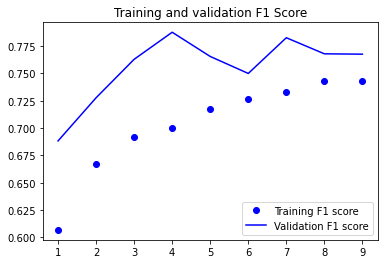

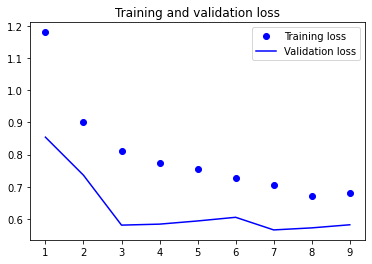

In [ ]:
f1_plots(history_incepv3)

In [ ]:
y_pred = incepv3.predict(X_test)
pred_arg = y_pred.argmax(axis=1)
co_mat = confusion_matrix(test_arg,pred_arg)

print(co_mat)
print(classification_report(test_arg,pred_arg))

Confusion matrix
[[116   8   1   3  16]
 [ 10 175   1   2  18]
 [  4   6  84   4  40]
 [ 23  15   8 101  25]
 [  3   7  19   4 171]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.74      0.81      0.77       144
   dandelion       0.83      0.85      0.84       206
        rose       0.74      0.61      0.67       138
   sunflower       0.89      0.59      0.71       172
       tulip       0.63      0.84      0.72       204

    accuracy                           0.75       864
   macro avg       0.77      0.74      0.74       864
weighted avg       0.77      0.75      0.75       864

None


# Collecting histories of all the models 

In [ ]:
models_list = ['history_1',
          'history_2',
          'history_3',
          'history_4',
          'history_5',
          'history_6',
          'history_7',
          'history_8',
          'history_9',
          'history_10',
          'history_11',
          'history_12',
          'history_13',
          'history_14',
          'history_vgg',
          'history_enetb7',
          'history_resnet152v2',
          'history_xception',
          'history_mobnetv3small',
          'history_resnet50v2',
          'history_incepv3']

In [ ]:
history_list = [max(history_1.history['val_f1_metric']),
 max(history_2.history['val_f1_metric']),
 max(history_3.history['val_f1_metric']),
 max(history_4.history['val_f1_metric']),
 max(history_5.history['val_f1_metric']),
 max(history_6.history['val_f1_metric']),
 max(history_7.history['val_f1_metric']),
 max(history_8.history['val_f1_metric']),
 max(history_9.history['val_f1_metric']),
 max(history_10.history['val_f1_metric']),
 max(history_11.history['val_f1_metric']),
 max(history_12.history['val_f1_metric']),
 max(history_13.history['val_f1_metric']),
 max(history_14.history['val_f1_metric']),
 max(history_vgg.history['val_f1_metric']),
 max(history_enetb7.history['val_f1_metric']),
 max(history_resnet152v2.history['val_f1_metric']),
 max(history_xception.history['val_f1_metric']),
 max(history_mobnetv3small.history['val_f1_metric']),
 max(history_resnet50v2.history['val_f1_metric']),
 max(history_incepv3.history['val_f1_metric'])]

In [ ]:
history_train_list = [max(history_1.history['f1_metric']),
 max(history_2.history['f1_metric']),
 max(history_3.history['f1_metric']),
 max(history_4.history['f1_metric']),
 max(history_5.history['f1_metric']),
 max(history_6.history['f1_metric']),
 max(history_7.history['f1_metric']),
 max(history_8.history['f1_metric']),
 max(history_9.history['f1_metric']),
 max(history_10.history['f1_metric']),
 max(history_11.history['f1_metric']),
 max(history_12.history['f1_metric']),
 max(history_13.history['f1_metric']),
 max(history_14.history['f1_metric']),
 max(history_vgg.history['f1_metric']),
 max(history_enetb7.history['f1_metric']),
 max(history_resnet152v2.history['f1_metric']),
 max(history_xception.history['f1_metric']),
 max(history_mobnetv3small.history['f1_metric']),
 max(history_resnet50v2.history['f1_metric']),
 max(history_incepv3.history['f1_metric'])]

In [ ]:
max_history_list = max(history_list)
max_index = history_list.index(max_history_list)
print(max_index)
print(models_list[max_index])

16
history_resnet152v2


In [ ]:
max_history_list = max(history_list)
max_index = history_list.index(max_history_list)
print('Model:',models_list[max_index].replace('history_', ''))
print('Train:',history_train_list[max_index])
print('Validation:',history_list[max_index])

Model: resnet152v2
Train: 0.8554061651229858
Validation: 0.8519046902656555


In [ ]:
history_1_df = pd.DataFrame.from_dict(history_1.history)
history_2_df = pd.DataFrame.from_dict(history_2.history)
history_3_df = pd.DataFrame.from_dict(history_3.history)
history_4_df = pd.DataFrame.from_dict(history_4.history)
history_5_df = pd.DataFrame.from_dict(history_5.history)
history_6_df = pd.DataFrame.from_dict(history_6.history)
history_7_df = pd.DataFrame.from_dict(history_7.history)
history_8_df = pd.DataFrame.from_dict(history_8.history)
history_9_df = pd.DataFrame.from_dict(history_9.history)
history_10_df = pd.DataFrame.from_dict(history_10.history)
history_11_df = pd.DataFrame.from_dict(history_11.history)
history_12_df = pd.DataFrame.from_dict(history_12.history)
history_13_df = pd.DataFrame.from_dict(history_13.history)
history_14_df = pd.DataFrame.from_dict(history_14.history)
history_vgg_df = pd.DataFrame.from_dict(history_vgg.history)
history_enetb7_df = pd.DataFrame.from_dict(history_enetb7.history)
history_resnet152v2_df = pd.DataFrame.from_dict(history_resnet152v2.history)
history_xception_df = pd.DataFrame.from_dict(history_xception.history)
history_mobnetv3small_df = pd.DataFrame.from_dict(history_mobnetv3small.history)
history_resnet50v2_df = pd.DataFrame.from_dict(history_resnet50v2.history)
history_incepv3_df = pd.DataFrame.from_dict(history_incepv3.history)

In [ ]:
history_1_df.to_csv('history_1_df.csv')
history_2_df.to_csv('history_2_df.csv')
history_3_df.to_csv('history_3_df.csv')
history_4_df.to_csv('history_4_df.csv')
history_5_df.to_csv('history_5_df.csv')
history_6_df.to_csv('history_6_df.csv')
history_7_df.to_csv('history_7_df.csv')
history_8_df.to_csv('history_8_df.csv')
history_9_df.to_csv('history_9_df.csv')
history_10_df.to_csv('history_10_df.csv')
history_11_df.to_csv('history_11_df.csv')
history_12_df.to_csv('history_12_df.csv')
history_13_df.to_csv('history_13_df.csv')
history_14_df.to_csv('history_14_df.csv')
history_vgg_df.to_csv('history_vgg_df.csv')
history_enetb7_df.to_csv('history_enetb7_df.csv')
history_resnet152v2_df.to_csv('history_resnet152v2_df.csv')
history_xception_df.to_csv('history_xception_df.csv')
history_mobnetv3small_df.to_csv('history_mobnetv3small_df.csv')
history_resnet50v2_df.to_csv('history_resnet50v2_df.csv')
history_incepv3_df.to_csv('history_incepv3.csv')

# Grid Search on the best model (RESNET152V2)

In [ ]:
def build_resnet(dense_activation, optimizer_choice, dense_neurons, dense_dropout, second_dense_layer):
  resnet = ResNet152V2(input_shape=shape, weights='imagenet', include_top=False)

  for layer in resnet.layers:
      layer.trainable = False
      
  z = Flatten()(resnet.output)

  # first hidden Dense layer
  z = Dense(units = dense_neurons, activation = dense_activation)(z)
  z = BatchNormalization()(z)
  z = Dropout(rate = dense_dropout)(z)

  # optional second hidden Dense layer
  if second_dense_layer != -1:
      z = Dense(units = second_dense_layer, activation = 'relu')(z)
      z = BatchNormalization()(z)
      z = Dropout(rate = 0.5)(z)

  # final Dense output layer
  z = Dense(units = 5, activation='softmax')(z)


  resnet152v2 = Model(inputs=resnet.input, outputs=z)

  resnet152v2.compile(optimizer = optimizer_choice,
                      loss='categorical_crossentropy', 
                      metrics=[f1_metric, 'accuracy'])

  return resnet152v2

In [ ]:
param_grid = {
    'dense_activation': ['relu'],
    'optimizer': ['Adam'],
    'dense_neurons': [256, 512, 1024],
    'dense_dropout': [0.3, 0.5, 0.7],
    'second_dense_layer' : [-1, 128]
}

In [ ]:
timestamp = datetime.now()
dfGrid = pd.DataFrame(columns = ['dense_activation', 'optimizer_choice', 'dense_neurons', 
                                 'dense_dropout', 'second_dense_layer', 'epochs',
                                 'train_loss', 'train_f1_metric', 'train_accuracy', 
                                 'val_loss', 'val_f1_metric', 'val_accuracy'])
counter = 0

for dense_act in param_grid['dense_activation']:
  for opt in param_grid['optimizer']:
    for dense_neur in param_grid['dense_neurons']:
      for dense_drop in param_grid['dense_dropout']:
        for second_layer in param_grid['second_dense_layer']:
          
          print('Training of combination ' + str(counter) + '...')
          counter += 1

          # build model with current grid params
          current_resnet = build_resnet(dense_activation = dense_act,
                                        optimizer_choice = opt,
                                        dense_neurons = dense_neur,
                                        dense_dropout = dense_drop, 
                                        second_dense_layer = second_layer)

          # train model
          currentHist = current_resnet.fit(train_generator,
                              epochs = 30,
                              validation_data = validation_generator,
                              callbacks = [earlystopping], 
                              verbose = 0
                            )

          # retrieve the index of epoch with maximal val_f1_score -> we wanna save the result of this epoch
          maxValF1 = max(currentHist.history['val_f1_metric'])
          maxValF1Index = currentHist.history['val_f1_metric'].index(maxValF1)
          #print(currentHist.history['val_f1_metric'])
          #print(maxValF1Index)

          currentRow = {
            'dense_activation': dense_act, 
            'optimizer_choice': opt, 
            'dense_neurons': dense_neur, 
            'dense_dropout': dense_drop, 
            'second_dense_layer': second_layer, 
            'epochs': maxValF1Index + 1,
            'train_loss': currentHist.history['loss'][maxValF1Index], 
            'train_f1_metric': currentHist.history['f1_metric'][maxValF1Index], 
            'train_accuracy': currentHist.history['accuracy'][maxValF1Index], 
            'val_loss': currentHist.history['val_loss'][maxValF1Index], 
            'val_f1_metric': currentHist.history['val_f1_metric'][maxValF1Index], 
            'val_accuracy': currentHist.history['val_accuracy'][maxValF1Index]
          }

          dfGrid = dfGrid.append(currentRow, ignore_index = True)

          # save the current version of the df so we wouldnt loose it
          dfGrid.to_csv('grid_' + str(timestamp) + '.csv')
          
dfGrid

Training of combination 0...
Restoring model weights from the end of the best epoch: 14.
Epoch 19: early stopping
Training of combination 1...
Restoring model weights from the end of the best epoch: 18.
Epoch 23: early stopping
Training of combination 2...
Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping
Training of combination 3...
Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
Training of combination 4...
Restoring model weights from the end of the best epoch: 18.
Epoch 23: early stopping
Training of combination 5...
Restoring model weights from the end of the best epoch: 21.
Epoch 26: early stopping
Training of combination 6...
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
Training of combination 7...
Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
Training of combination 8...
Restoring model weights from the end of the best epoch: 9.
Ep

,dense_activation,optimizer_choice,dense_neurons,dense_dropout,second_dense_layer,epochs,train_loss,train_f1_metric,train_accuracy,val_loss,val_f1_metric,val_accuracy
0,relu,Adam,256,0.3,-1,14,0.405430,0.847934,0.850193,0.459355,0.841597,0.840093
1,relu,Adam,256,0.3,128,18,0.464737,0.836031,0.831660,0.451516,0.839093,0.826188
2,relu,Adam,256,0.5,-1,8,0.523658,0.802830,0.805405,0.421518,0.848829,0.842410
3,relu,Adam,256,0.5,128,13,0.592972,0.776057,0.775676,0.435524,0.844089,0.838934
4,relu,Adam,256,0.7,-1,18,0.507128,0.823328,0.825869,0.449771,0.847828,0.838934
5,relu,Adam,256,0.7,128,21,0.543736,0.800444,0.798069,0.424506,0.840578,0.837775
6,relu,Adam,512,0.3,-1,6,0.487673,0.820823,0.816216,0.470473,0.831597,0.831981
7,relu,Adam,512,0.3,128,13,0.495503,0.820239,0.821622,0.432251,0.850472,0.842410
8,relu,Adam,512,0.5,-1,9,0.519719,0.819051,0.816216,0.476525,0.833945,0.829664
9,relu,Adam,512,0.5,128,14,0.532715,0.808603,0.811197,0.446474,0.838797,0.833140


In [ ]:
dfGrid = pd.read_csv('/content/grid_' + str(timestamp) + '.csv')

In [ ]:
# retrieve the best hyperparameter combination
bestIndex = dfGrid['val_f1_metric'].idxmax()
bestParams = dfGrid.iloc[bestIndex][['dense_activation', 'optimizer_choice', 'dense_neurons', 
                                 'dense_dropout', 'second_dense_layer']].to_dict()
optimalNumberOfEpochs = dfGrid.iloc[bestIndex]['epochs']

print('Best val f1 score found in line: ' + str(bestIndex))
print('Optimal number of epochs to train: ' + str(optimalNumberOfEpochs))
print(bestParams)

Best val f1 score found in line: 13
Optimal number of epochs to train: 15
{'dense_activation': 'relu', 'optimizer_choice': 'Adam', 'dense_neurons': 1024, 'dense_dropout': 0.3, 'second_dense_layer': 128}


# Train the best model with the best hyperparams on the whole training set

In [ ]:
# concat train and validation sets
X_train_val = np.concatenate((X_train, X_val), axis = 0)
y_train_val = np.concatenate((y_train, y_val), axis = 0)

# augment 
train_val_generator = train_datagen.flow(X_train_val, y_train_val)

print(X_train_val.shape)
print(y_train_val.shape)

(3453, 126, 169, 3)
(3453, 5)


In [ ]:
# build the best model using the best hyperparams on the merged train + validation set 

best_model = build_resnet(**bestParams)
best_model_history = best_model.fit(train_val_generator, epochs = optimalNumberOfEpochs)
best_model.save('flower_labeling_best_model.h5')

Epoch 1/15
108/108 [==============================] - 43s 288ms/step - loss: 1.1018 - f1_metric: 0.6353 - accuracy: 0.6400
Epoch 2/15
108/108 [==============================] - 30s 271ms/step - loss: 0.7781 - f1_metric: 0.7283 - accuracy: 0.7284
Epoch 3/15
108/108 [==============================] - 30s 273ms/step - loss: 0.6791 - f1_metric: 0.7537 - accuracy: 0.7579
Epoch 4/15
108/108 [==============================] - 29s 271ms/step - loss: 0.6002 - f1_metric: 0.7739 - accuracy: 0.7735
Epoch 5/15
108/108 [==============================] - 29s 269ms/step - loss: 0.5825 - f1_metric: 0.7941 - accuracy: 0.7947
Epoch 6/15
108/108 [==============================] - 29s 270ms/step - loss: 0.5458 - f1_metric: 0.7973 - accuracy: 0.7979
Epoch 7/15
108/108 [==============================] - 29s 267ms/step - loss: 0.5304 - f1_metric: 0.8136 - accuracy: 0.8144
Epoch 8/15
108/108 [==============================] - 29s 268ms/step - loss: 0.5133 - f1_metric: 0.8195 - accuracy: 0.8173
Epoch 9/15
108/1

# Predictions on the test dataset

In [ ]:
prediction = best_model.predict(X_test)
print('Test Dataset F1 score:', f1_metric(y_test, prediction).numpy())
print(classification_report(test_arg, prediction.argmax(axis=1)))
print(confusion_matrix(test_arg, prediction.argmax(axis=1)))

Test Dataset F1 score: 0.82211536
Classification Report
              precision    recall  f1-score   support

       daisy       0.90      0.77      0.83       144
   dandelion       0.82      0.89      0.86       206
        rose       0.75      0.82      0.78       138
   sunflower       0.84      0.75      0.79       172
       tulip       0.82      0.85      0.83       204

    accuracy                           0.82       864
   macro avg       0.83      0.82      0.82       864
weighted avg       0.83      0.82      0.82       864

None
Confusion matrix
[[111  17   6   8   2]
 [  4 184   3   4  11]
 [  2   4 113   7  12]
 [  4  14  11 129  14]
 [  2   5  17   6 174]]


In [ ]:
bestParams = {'dense_activation': 'relu', 'optimizer_choice': 'Adam', 'dense_neurons': 1024, 'dense_dropout': 0.3, 'second_dense_layer': 128}
best_model = build_resnet(**bestParams)
best_model_history = best_model.fit(train_val_generator, epochs = 15)
best_model.save('flower_labeling_best_model.h5')


Epoch 1/15
108/108 [==============================] - 52s 284ms/step - loss: 1.0518 - f1_metric: 0.6486 - accuracy: 0.6458
Epoch 2/15
108/108 [==============================] - 30s 278ms/step - loss: 0.7988 - f1_metric: 0.7218 - accuracy: 0.7231
Epoch 3/15
108/108 [==============================] - 30s 278ms/step - loss: 0.6771 - f1_metric: 0.7558 - accuracy: 0.7533
Epoch 4/15
108/108 [==============================] - 30s 272ms/step - loss: 0.5844 - f1_metric: 0.7846 - accuracy: 0.7831
Epoch 5/15
108/108 [==============================] - 30s 272ms/step - loss: 0.5796 - f1_metric: 0.7857 - accuracy: 0.7860
Epoch 6/15
108/108 [==============================] - 31s 283ms/step - loss: 0.5375 - f1_metric: 0.8066 - accuracy: 0.8077
Epoch 7/15
108/108 [==============================] - 31s 285ms/step - loss: 0.5171 - f1_metric: 0.8171 - accuracy: 0.8155
Epoch 8/15
108/108 [==============================] - 30s 272ms/step - loss: 0.4880 - f1_metric: 0.8148 - accuracy: 0.8123
Epoch 9/15
108/1

In [ ]:
prediction = best_model.predict(X_test)
print('Test Dataset F1 score:', f1_metric(y_test, prediction).numpy())
print(classification_report(test_arg, prediction.argmax(axis=1)))
print(confusion_matrix(test_arg, prediction.argmax(axis=1)))

Test Dataset F1 score: 0.8309352
Classification Report
              precision    recall  f1-score   support

       daisy       0.85      0.84      0.84       144
   dandelion       0.90      0.85      0.87       206
        rose       0.75      0.78      0.77       138
   sunflower       0.85      0.80      0.83       172
       tulip       0.80      0.86      0.83       204

    accuracy                           0.83       864
   macro avg       0.83      0.83      0.83       864
weighted avg       0.83      0.83      0.83       864

None
Confusion matrix
[[121   6   7   8   2]
 [ 10 175   4   7  10]
 [  5   2 108   3  20]
 [  5   8   8 138  13]
 [  2   4  17   6 175]]


In [ ]:
for i in range(len(y_test)):
  testLabel, predLabel = y_test[i], prediction[i]
  #print(testLabel, predLabel)
  

  if testLabel[2] == 1 and predLabel.argmax(axis=0) != 2:
    predLabelCopy = [i for i in predLabel]
    
    
    print(i, testLabel, predLabel, np.where((np.sort(predLabel)[::-1]) == predLabel[2])[0])

0 [0. 0. 1. 0. 0.] [0.68654114 0.27856684 0.01463928 0.0104875  0.00976519] [2]
27 [0. 0. 1. 0. 0.] [7.65049990e-05 4.49158651e-05 1.09315254e-01 4.17776464e-05
 8.90521586e-01] [1]
38 [0. 0. 1. 0. 0.] [0.01544267 0.0029125  0.23423505 0.6834258  0.063984  ] [1]
73 [0. 0. 1. 0. 0.] [1.0460863e-04 1.3789398e-02 4.5511782e-01 3.4850146e-04 5.3063965e-01] [1]
87 [0. 0. 1. 0. 0.] [0.17418772 0.13911289 0.21588863 0.03074618 0.44006455] [1]
90 [0. 0. 1. 0. 0.] [0.57649773 0.36960217 0.0177858  0.02391751 0.01219677] [3]
101 [0. 0. 1. 0. 0.] [0.00721166 0.00106131 0.04890597 0.54074913 0.40207198] [2]
121 [0. 0. 1. 0. 0.] [0.0473589  0.02752274 0.19305927 0.64600223 0.0860569 ] [1]
176 [0. 0. 1. 0. 0.] [4.1778979e-04 6.6222833e-04 1.7348757e-01 6.6024535e-03 8.1882995e-01] [1]
197 [0. 0. 1. 0. 0.] [0.7626712  0.05827148 0.14595199 0.01461702 0.01848832] [1]
241 [0. 0. 1. 0. 0.] [0.10964622 0.01154625 0.10092525 0.10422444 0.67365783] [3]
249 [0. 0. 1. 0. 0.] [6.9272262e-04 7.0298644e-05 4.93

864 864


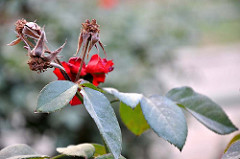

In [ ]:
testImagePaths = imagePaths[valSplitPoint:]
print(testImagePaths.shape[0], X_test.shape[0])
Image.open('flowers/flowers/rose/' + testImagePaths[853])

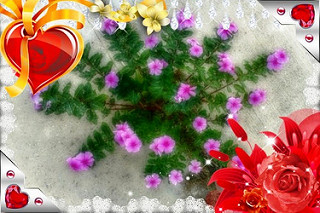

In [ ]:

Image.open('flowers/flowers/rose/' + testImagePaths[606])

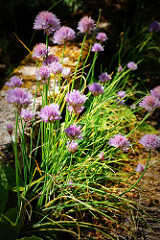

In [ ]:
Image.open('flowers/flowers/rose/' + testImagePaths[90])

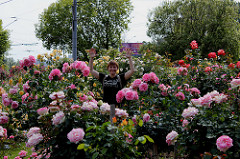

In [ ]:
Image.open('flowers/flowers/rose/' + testImagePaths[241])